#  顺序到序列学习
:label:`sec_seq2seq`

正如我们在 :numref:`sec_machine_translation` 中看到的那样，在机器翻译中，输入和输出都是一个可变长度的序列。为了解决这类问题，我们在 :numref:`sec_encoder-decoder` 中设计了一种通用的编码器解码器架构。在本节中，我们将使用两类 RNN 来设计此架构的编码器和解码器，并将其应用于机器翻译 :cite:`Sutskever.Vinyals.Le.2014,Cho.Van-Merrienboer.Gulcehre.ea.2014` 的 **序列到序列**（sequence to sequence） 学习。

遵循编码器解码器架构的设计原理，RNN 编码器可以采用可变长度序列作为输入，并将其转换为固定形状的隐藏状态。换句话说，输入（源）序列的信息被编码 RNN 编码器的隐藏状态。要通过令牌生成输出序列令牌，单独的 RNN 解码器可以根据已看到的（例如在语言建模中）或生成的令牌以及输入序列的编码信息来预测下一个令牌。:numref:`fig_seq2seq` 说明了如何使用两个 RNN 进行序列顺序学习机器翻译。

![Sequence to sequence learning with an RNN encoder and an RNN decoder.](../img/seq2seq.svg)
:label:`fig_seq2seq`

在 :numref:`fig_seq2seq` 中，特殊的 “&lt;eos>” 令牌标志着序列的结束。生成此令牌后，模型可以停止进行预测。在 RNN 解码器的初始时间步，有两个特殊的设计决策。首先，特殊的序列开始 “&lt;bos>” 令牌是输入。其次，RNN 编码器的最终隐藏状态用于启动解码器的隐藏状态。在 :cite:`Sutskever.Vinyals.Le.2014` 等设计中，这正是将编码输入序列信息输入解码器以生成输出（目标）序列的方式。在其他一些设计中，如 :cite:`Cho.Van-Merrienboer.Gulcehre.ea.2014`，编码器的最终隐藏状态也会作为每个时间步的输入的一部分送入解码器，如 :numref:`fig_seq2seq` 所示。与 :numref:`sec_language_model` 中的语言模型训练类似，我们可以允许标签成为原始输出序列，由一个标记移动：“&lt;bos>”、“Ils”、“regardent”、“.” $\rightarrow$ “Ils”，“regardent”，“.”， “&lt;eos>”。

在下面，我们将更详细地解释 :numref:`fig_seq2seq` 的设计。我们将在 :numref:`sec_machine_translation` 中引入的英法数据集上训练这种模型，用于机器翻译。


In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

## 编码器

从技术上讲，编码器将可变长度的输入序列转换为固定形状的 * 上下文变量 * $\mathbf{c}$，并在此上下文变量中对输入序列信息进行编码。如 :numref:`fig_seq2seq` 所示，我们可以使用 RNN 来设计编码器。

让我们考虑一个序列示例（批量大小：1）。假设输入序列是 $x_1, \ldots, x_T$，因此 $x_t$ 是输入文本序列中的 $t^{\mathrm{th}}$ 标记。在时间步骤 $t$ 中，RNN 将 $x_t$ 的输入要素矢量 $\mathbf{x}_t$ 和从上一个时间步的隐藏状态 $\mathbf{h} _{t-1}$ 转换为当前隐藏状态 $\mathbf{h}_t$。我们可以使用函数 $f$ 来表达 RNN 循环层的转换：

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

一般来说，编码器通过自定义函数 $q$ 将隐藏状态转换为上下文变量：

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

例如，当选择 $q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$（如 :numref:`fig_seq2seq`）时，上下文变量只是输入序列在最后一个时间步的隐藏状态 $\mathbf{h}_T$。

到目前为止，我们使用了单向 RNN 来设计编码器，其中隐藏状态只取决于隐藏状态时间步长和之前的输入子序列。我们还可以使用双向 RNN 构建编码器。在这种情况下，隐藏状态取决于时间步长之前和之后的子序列（包括当前时间步长的输入），后者对整个序列的信息进行编码。

现在让我们实施 RNN 编码器。请注意，我们使用 * 嵌入层 * 来获取输入序列中每个令牌的特征矢量。嵌入图层的权重是一个矩阵，其行数等于输入词汇表的大小 (`vocab_size`)，列数等于要素矢量的维度 (`embed_size`)。对于任何输入令牌索引 $i$，嵌入层将获取权重矩阵的 $i^{\mathrm{th}}$ 行（从 0 开始）以返回其要素矢量。此外，我们在这里选择一个多层 GRU 来实现编码器。


In [2]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

:numref:`sec_rnn-concise` 中已对循环层的返回变量进行了解释。让我们仍然用一个具体的例子来说明上述编码器的实现。下面我们实例化一个双层 GRU 编码器，其隐藏单位数为 16 个。鉴于小批量序列输入 `X`（批量大小：4，时间步长数：7），所有时间步长中最后一层的隐藏状态（编码器的循环层返回 `output`）是形状的张量（时间步长数、批量大小、隐藏单位数）。


In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

由于此处使用 GRU，因此最后一个时间步长的多层隐藏状态的形状为（隐藏层数、批量大小、隐藏单位数量）。如果使用 LSTM，则记忆单元信息也将包含在 `state` 中。


In [4]:
state.shape

torch.Size([2, 4, 16])

## 解码器
:label:`sec_seq2seq_decoder`

正如我们刚才提到的，编码器输出的上下文变量 $\mathbf{c}$ 对整个输入序列 $x_1, \ldots, x_T$ 进行编码。鉴于训练数据集的输出序列 $y_1, y_2, \ldots, y_{T'}$，对于每个时间步长 $t'$（符号不同于输入序列或编码器的时间步长 $t$），解码器输出 $y_{t'}$ 的概率取决于之前的输出子序列 $y_1, \ldots, y_{t'-1}$ 和上下文变量$\mathbf{c}$，即 $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$。

要对序列进行这种条件概率建模，我们可以使用另一个 RNN 作为解码器。在输出序列的任何时间步骤 $t^\prime$，RNN 将上一个时间步的输出 $y_{t^\prime-1}$ 和上下文变量 $\mathbf{c}$ 作为输入，然后将它们和之前的隐藏状态 $\mathbf{s}_{t^\prime-1}$ 转换为当前时间步长的隐藏状态 $\mathbf{s}_{t^\prime}$。因此，我们可以使用函数 $g$ 来表达解码器隐藏层的转换：

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$
:eqlabel:`eq_seq2seq_s_t`

获得解码器的隐藏状态后，我们可以使用输出层和 softmax 操作来计算时间步骤 $t^\prime$ 时输出的条件概率分布 $P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$。

在 :numref:`fig_seq2seq` 之后，在按如下方式实现解码器时，我们直接使用编码器最后一个时间步的隐藏状态来初始化解码器的隐藏状态。这要求 RNN 编码器和 RNN 解码器具有相同数量的层和隐藏单位。为了进一步合并编码的输入序列信息，上下文变量会在所有时间步长与解码器输入连接起来。为了预测输出令牌的概率分布，使用完全连接的层来转换 RNN 解码器最后一层的隐藏状态。


In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

为了说明实现的解码器，下面我们使用上述编码器中的相同超参数对其进行实例化。正如我们所看到的，解码器的输出形状变为（批量大小、时间步长数、词汇量），张量的最后一个维度存储预测的令牌分布。


In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

总而言之，上面的 RNN 编码器-解码器模型中的各层在 :numref:`fig_seq2seq_details` 中进行了说明。

![Layers in an RNN encoder-decoder model.](../img/seq2seq-details.svg)
:label:`fig_seq2seq_details`

## 损失函数

在每个时间步骤中，解码器都会预测输出令牌的概率分布。与语言建模类似，我们可以应用 softmax 来获取分布并计算交叉熵损失以进行优化。回想一下 :numref:`sec_machine_translation`，特殊的填充令牌被附加到序列的末尾，因此可以将不同长度的序列高效地装入相同形状的小批次。但是，对填充令牌的预测应该从损失计算中排除。

为此，我们可以使用以下 `sequence_mask` 函数以零值掩盖无关条目，以便稍后将任何不相关的预测乘以零等于零。例如，如果不包括填充标记的两个序列的有效长度分别为 1 和 2，则第一个和前两个条目之后的剩余条目将被清除为零。


In [7]:
#@save
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

我们还可以掩盖最后几个轴上的所有条目。如果你愿意，你甚至可以指定用非零值替换这些条目。


In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

现在我们可以延长 softmax 交叉熵损失，以允许掩盖不相关的预测。最初，所有预测令牌的掩码都设置为一个。一旦给出了有效长度，与任何填充令牌对应的掩码将被清除为零。最后，所有代币的损失将乘以掩码，以过滤掉对损失中填充令牌的无关预测。


In [9]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

为了进行健全性检查，我们可以创建三个相同的序列。然后我们可以指定这些序列的有效长度分别为 4、2 和 0。因此，第一个序列的损失应该是第二个序列的两倍，而第三个序列的损失应为零损失。


In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## 培训
:label:`sec_seq2seq_training`

在接下来的训练循环中，我们连接了特殊的序列开始令牌和原始输出序列，不包括最终令牌作为解码器的输入，如 :numref:`fig_seq2seq` 所示。这被称为 *教师forcing*，因为原始输出序列（令牌标签）被输入到解码器中。或者，我们还可以将上一个时间步中的 *预测ted* 令牌作为解码器的当前输入。


In [11]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

现在我们可以创建和训练 RNN 编码器解码器模型，以便在机器翻译数据集上进行序列到序列学习。


loss 0.020, 11111.8 tokens/sec on cuda:0


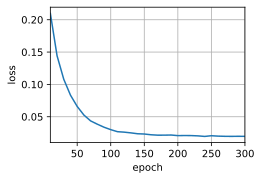

In [12]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 预测

要通过令牌预测输出序列令牌，在每个解码器时间步长，上一个时间步的预测令牌作为输入输入进入解码器。与训练类似，在初始时间步骤，序列开始（” <bos> “）令牌被输入到解码器中。:numref:`fig_seq2seq_predict` 中说明了这一预测过程。当预测序列结束 (” <eos> “) 令牌时，输出序列的预测将完成。

![Predicting the output sequence token by token using an RNN encoder-decoder.](../img/seq2seq-predict.svg)
:label:`fig_seq2seq_predict`

我们将在 :numref:`sec_beam-search` 中引入不同的序列生成策略。


In [13]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## 预测序列的评估

我们可以通过将预测序列与标签序列（基本真实）进行比较来评估该序列。BLEU（双语评估小学）虽然最初建议用于评估机器翻译结果 :cite:`Papineni.Roukos.Ward.ea.2002`，但已广泛用于测量不同应用的输出序列的质量。原则上，对于预测序列中的任何 $n$ 克，BLEU 会评估这 $n$ 克是否出现在标签序列中。

用 $p_n$ 表示 $n$ 克的精度，这是预测序列和标签序列中匹配的 $n$ 克数与预测序列中 $n$ 克数的比率。解释一下，给定标签序列 $B$、$B$、$C$、$D$、$F$ 和预测序列 $F$ 和预测序列 $B$、$B$、$B$、$C$、$D$，我们有 $p_2 = 3/4$ 3624 和 $p_4 = 0$。此外，让 $\mathrm{len}_{\text{label}}$ 和 $\mathrm{len}_{\text{pred}}$ 分别成为标签序列和预测序列中的令牌数量。然后，BLEU 被定义为

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

其中 $k$ 是匹配时间最长的 $n$ 克。

根据 :eqref:`eq_bleu` 中 BLEU 的定义，只要预测的序列与标签序列相同，BLEU 就为 1。此外，由于匹配更长的 $n$ 克更困难，BLEU 将更大的权重分配给更长的 $n$ 克精度。具体来说，当 $p_n$ 固定时，$p_n^{1/2^n}$ 随着 $n$ 的增长而增加（原纸使用 $p_n^{1/n}$）。此外，由于预测较短的序列往往会获得更高的 $p_n$ 值，因此 :eqref:`eq_bleu` 中乘法项之前的系数将惩罚较短的预测序列。例如，在考虑到标签序列 $k=2$、$B$、$C$、$E$、$F$ 和预测序列 $B$（尽管 $B$）的情况下，鉴于标签序列 $B$、$B$，但罚因子 $\exp(1-6/2) \approx 0.14$ 降低了蓝效单元。

我们按如下方式实施 BLEU 措施。


In [14]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

最后，我们使用训练有素的 RNN 编码器将一些英语句子翻译成法语并计算结果的 BLEU。


In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est riche ., bleu 0.658
i'm home . => je suis chez chez moi <unk> <unk> ., bleu 0.640


## 摘要

* 按照编码器解码器架构的设计，我们可以使用两个 RNN 来设计一个用于序列到序列学习的模型。
* 在实施编码器和解码器时，我们可以使用多层 RNN。
* 我们可以使用掩码来过滤掉不相关的计算，例如在计算损失时。
* 在编码器解码器培训中，教师强制方法将原始输出序列（与预测相比）输入解码器。
* BLEU 是通过在预测序列和标签序列之间匹配 $n$ 克来评估输出序列的常用措施。

## 练习

1. 你能调整超参数以改善翻译结果吗？
1. 在损失计算中不使用口罩重新运行实验。你观察到什么结果？为什么？
1. 如果编码器和解码器在层数或隐藏单位数量上有所不同，我们该如何初始化解码器的隐藏状态？
1. 在培训中，将教师强制改为将前一时间步骤的预测输入解码器。这对表现有何影响？
1. 通过用 LSTM 替换 GRU 来重新运行实验。
1. 还有其他方法可以设计解码器的输出层吗？


[Discussions](https://discuss.d2l.ai/t/1062)
